# COVID-19 and Viral Pneumonia Detection Tool
### 1. Loading and Exploring Dataset

In [1]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
data_path = pathlib.Path("/Users/jiangjiang/Downloads/COVID_IEEE")  
assert data_path.exists(), "Dataset folder not found"

In [3]:
# === Count Images in Each Class ===
counts = {folder.name: len(list(folder.glob("*")))
          for folder in data_path.iterdir() if folder.is_dir()}

print("Number of images in each class:")
for label, count in counts.items():
    print(f"{label}: {count}")

Number of images in each class:
normal: 668
covid: 536
virus: 619


In [4]:
# === Create Data Frame ===
data = [(str(img), folder.name) for folder in data_path.iterdir() if folder.is_dir() for img in folder.glob("*")]
df = pd.DataFrame(data, columns=["filepath", "label"])

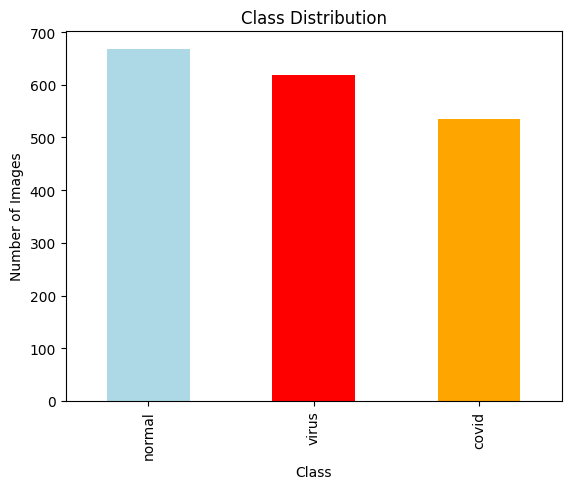

In [5]:
# ==== Class Distribution ===
df["label"].value_counts().plot(kind="bar", color=['lightblue','red','orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Found 1708 files belonging to 3 classes.


2025-11-19 19:43:35.264416: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-19 19:43:35.264465: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-11-19 19:43:35.264470: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2025-11-19 19:43:35.264506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-19 19:43:35.264522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-19 19:43:35.636297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


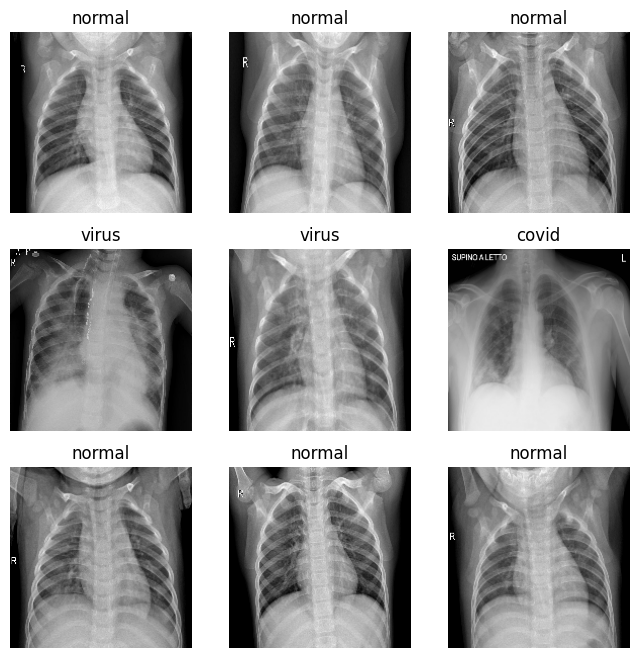

In [6]:
# === Load/Display Images ===
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(180, 180),
    batch_size=9,
    shuffle=True
)

class_names = dataset.class_names
plt.figure(figsize=(8,8))
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 2. Build & Train Baseline CNN Model

### (a) Data prep

In [7]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180
random_seed = 42

# 1. Training Dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 2. Validation Dataset (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 3. Configure for performance (cache in memory)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

Found 1708 files belonging to 3 classes.
Using 1367 files for training.
Found 1708 files belonging to 3 classes.
Using 341 files for validation.


### (b) Baseline Model

In [8]:
def build_baseline_model():
    model = models.Sequential([
        # Rescale inputs from [0, 255] to [0, 1]
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        # Conv Block 1
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Conv Block 2
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Conv Block 3
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Dense Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print("Training Baseline Model...")
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15  # Standard starting point
)

Training Baseline Model...
Epoch 1/15


/opt/anaconda3/envs/cxr-mac/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-19 19:43:36.394228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6474 - loss: 0.9819 - val_accuracy: 0.8680 - val_loss: 0.3928
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8859 - loss: 0.3314 - val_accuracy: 0.8944 - val_loss: 0.2958
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9086 - loss: 0.2662 - val_accuracy: 0.9179 - val_loss: 0.2134
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9429 - loss: 0.1614 - val_accuracy: 0.9238 - val_loss: 0.2289
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9488 - loss: 0.1441 - val_accuracy: 0.9384 - val_loss: 0.1736
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9444 - loss: 0.1363 - val_accuracy: 0.9267 - val_loss: 0.2736
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9663 - loss: 0.1026 - val_accuracy: 0.9413 - val_loss: 0.2196
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9517 - loss: 0.1346 - val_accuracy: 0.9296 - val_loss: 0.

### (c) Improved Model

Data Augmentation and Regularization.

In [9]:
from tensorflow.keras import layers, models
# 1. Lighter Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.05), 
  layers.RandomZoom(0.05),     
])

def build_tuned_model():
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        
        # Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Block 4
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Dropout(0.2),
        layers.Flatten(),
        
        # Dense Head
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

improved_model = build_tuned_model()
improved_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Define early_stopping before using it
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history_improved = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=[early_stopping] 
)

Epoch 1/30


/opt/anaconda3/envs/cxr-mac/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5633 - loss: 0.8587 - val_accuracy: 0.8152 - val_loss: 0.5237
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7754 - loss: 0.5262 - val_accuracy: 0.9150 - val_loss: 0.2746
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8566 - loss: 0.3707 - val_accuracy: 0.9179 - val_loss: 0.2691
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8947 - loss: 0.3242 - val_accuracy: 0.9120 - val_loss: 0.2465
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8881 - loss: 0.3145 - val_accuracy: 0.9150 - val_loss: 0.2580
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8822 - loss: 0.3330 - val_accuracy: 0.9326 - val_loss: 0.2466
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9078 - loss: 0.2877 - val_accuracy: 0.9238 - val_loss: 0.3233
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9327 - loss: 0.2262 - val_accuracy: 0.9326 - val_loss: 0.

### (d) Pre-trained Model

In [10]:
# 1. Load the pre-trained base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3), 
    include_top=False,  # Exclude the classifier layers from the original model
    weights='imagenet'
)

# 2. Freeze the base model
# We don't want to destroy the learned patterns, so we make it non-trainable
base_model.trainable = False

# 3. Build the new model on top
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') # 3 classes: Normal, Covid, Virus
])

# 4. Compile
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 5. Train
print("Starting Transfer Learning...")
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

/var/folders/3k/nv285bxx7137ks9g2k__z_qm0000gn/T/ipykernel_88810/3354862294.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Starting Transfer Learning...
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.4923 - loss: 1.0188 - val_accuracy: 0.6862 - val_loss: 0.8201
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6013 - loss: 0.8763 - val_accuracy: 0.7243 - val_loss: 0.7261
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6474 - loss: 0.7890 - val_accuracy: 0.7478 - val_loss: 0.6707
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7118 - loss: 0.7082 - val_accuracy: 0.7801 - val_loss: 0.6176
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7513 - loss: 0.6482 - val_accuracy: 0.8065 - val_loss: 0.5755
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7315 - loss: 0.6424 - val_accuracy: 0.8152 - val_loss: 0.5458
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7498 - loss: 0.6144 - val_accuracy: 0.8328 - val_loss: 0.5190
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7688 - loss: 0.

### (e) Fine-Tuning

In [11]:
# ==========================================
# STEP 1: INITIAL TRANSFER LEARNING (FROZEN)
# ==========================================

# 1. Load the pre-trained base model (MobileNetV2)
# We use include_top=False to exclude the ImageNet classifier at the top
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3), 
    include_top=False, 
    weights='imagenet'
)

# 2. Freeze the base model
# This prevents the pre-trained weights from being destroyed during the initial training
base_model.trainable = False

# 3. Build the classifier head
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') # 3 classes: Normal, Covid, Virus
])

# 4. Compile the model
# We use a standard learning rate (0.0001) for this phase
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 5. Train the top layer (Transfer Learning)
print("Starting Initial Transfer Learning...")
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# 1. Define the Early Stopping Callback
early_stopping_fine = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # Watch the validation loss
    patience=5,               # Stop if loss doesn't improve for 5 epochs
    restore_best_weights=True, # CRITICAL: Revert to the weights from the best epoch
    verbose=1
)

# 2. Unfreeze the base model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Recompile (Low Learning Rate)
transfer_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# 4. Train with the Callback
print("Starting Fine-Tuning with Early Stopping...")

total_epochs = 50 # Set a high cap, let Early Stopping decide when to stop

history_fine = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1],
    callbacks=[early_stopping_fine] 
)


/var/folders/3k/nv285bxx7137ks9g2k__z_qm0000gn/T/ipykernel_88810/129761524.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Starting Initial Transfer Learning...
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.4740 - loss: 1.1528 - val_accuracy: 0.5543 - val_loss: 0.9345
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5252 - loss: 1.0111 - val_accuracy: 0.6422 - val_loss: 0.8174
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6050 - loss: 0.8857 - val_accuracy: 0.7155 - val_loss: 0.7316
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6379 - loss: 0.7996 - val_accuracy: 0.7155 - val_loss: 0.6728
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6774 - loss: 0.7306 - val_accuracy: 0.7654 - val_loss: 0.6361
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7220 - loss: 0.6801 - val_accuracy: 0.7801 - val_loss: 0.5959
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7220 - loss: 0.6627 - val_accuracy: 0.8065 - val_loss: 0.5608
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7374 - 

### 4. Evaluate Model Performances

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_ds, class_names, title="Model"):
    y_true = []
    y_pred = []

    for imgs, labels in test_ds:
        probs = model.predict(imgs, verbose=0)
        preds = np.argmax(probs, axis=1)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # === Classification Report ===
    print(f"\n===== {title}: Classification Report =====\n")
    print(classification_report(
        y_true, y_pred, target_names=class_names, zero_division=0
    ))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{title}: Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()



===== Baseline CNN: Classification Report =====

              precision    recall  f1-score   support

       covid       0.96      0.95      0.95        77
      normal       0.93      0.94      0.94       125
       virus       0.94      0.94      0.94       139

    accuracy                           0.94       341
   macro avg       0.94      0.94      0.94       341
weighted avg       0.94      0.94      0.94       341



2025-11-19 20:00:38.343844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


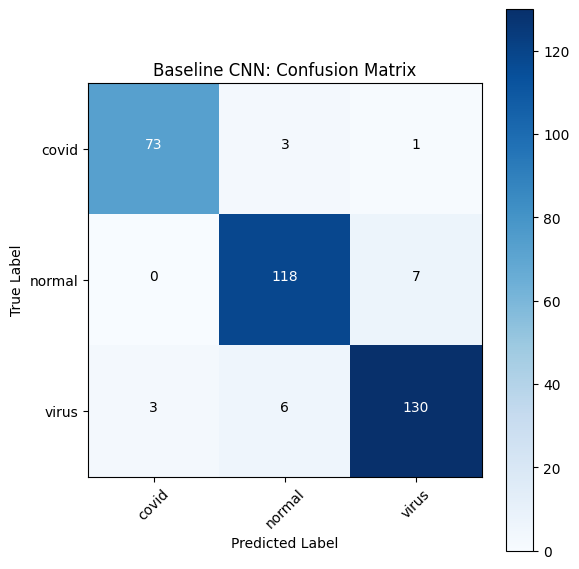

In [17]:
# ------ Baseline Model Evaluation -------
evaluate_model(baseline_model, val_ds, class_names, "Baseline CNN")


===== Improved CNN: Classification Report =====

              precision    recall  f1-score   support

       covid       0.93      0.97      0.95        77
      normal       0.92      0.95      0.94       125
       virus       0.95      0.90      0.93       139

    accuracy                           0.94       341
   macro avg       0.93      0.94      0.94       341
weighted avg       0.94      0.94      0.94       341



2025-11-19 20:00:46.998038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


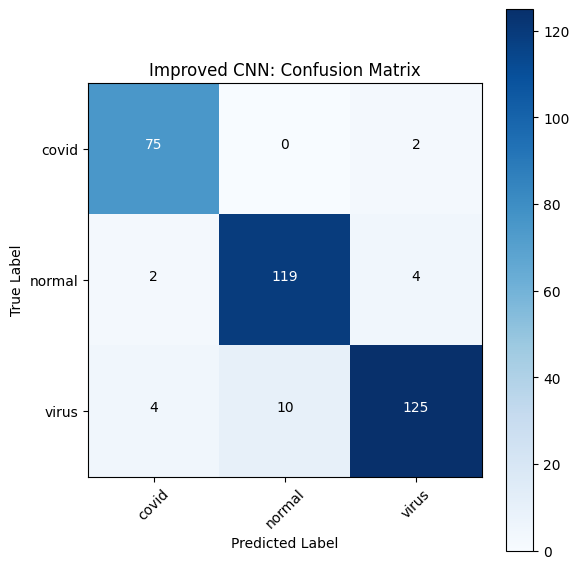

In [18]:
# ------- Improved CNN Evaluation --------
evaluate_model(improved_model, val_ds, class_names, "Improved CNN")


===== Transfer Learning Model: Classification Report =====

              precision    recall  f1-score   support

       covid       0.95      0.90      0.92        77
      normal       0.91      0.86      0.88       125
       virus       0.86      0.94      0.90       139

    accuracy                           0.90       341
   macro avg       0.91      0.90      0.90       341
weighted avg       0.90      0.90      0.90       341



2025-11-19 20:00:55.896000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


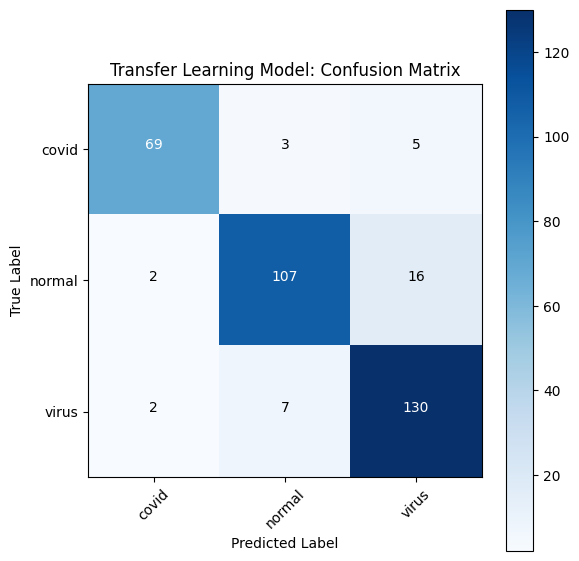

In [19]:
# ------ Transfer Learning Model -------
evaluate_model(transfer_model, val_ds, class_names, "Transfer Learning Model")


===== Fine-Tuned MobileNetV2: Classification Report =====

              precision    recall  f1-score   support

       covid       0.95      0.90      0.92        77
      normal       0.91      0.86      0.88       125
       virus       0.86      0.94      0.90       139

    accuracy                           0.90       341
   macro avg       0.91      0.90      0.90       341
weighted avg       0.90      0.90      0.90       341



2025-11-19 20:01:03.320357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


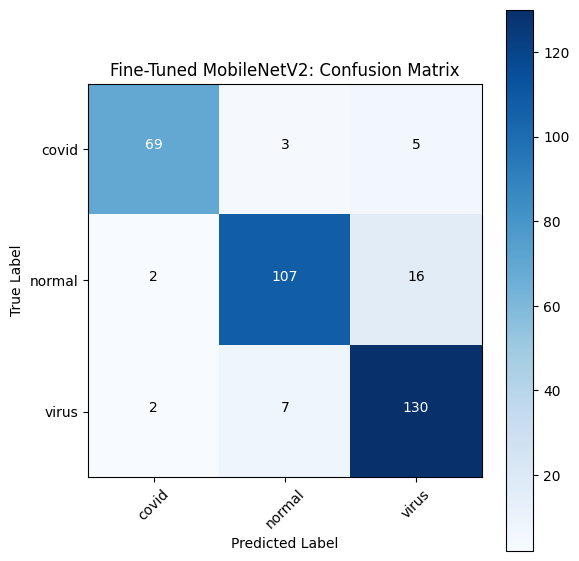

In [20]:
# ------ Fine-Tuned MobileNetV2 -------
evaluate_model(transfer_model, val_ds, class_names, "Fine-Tuned MobileNetV2")

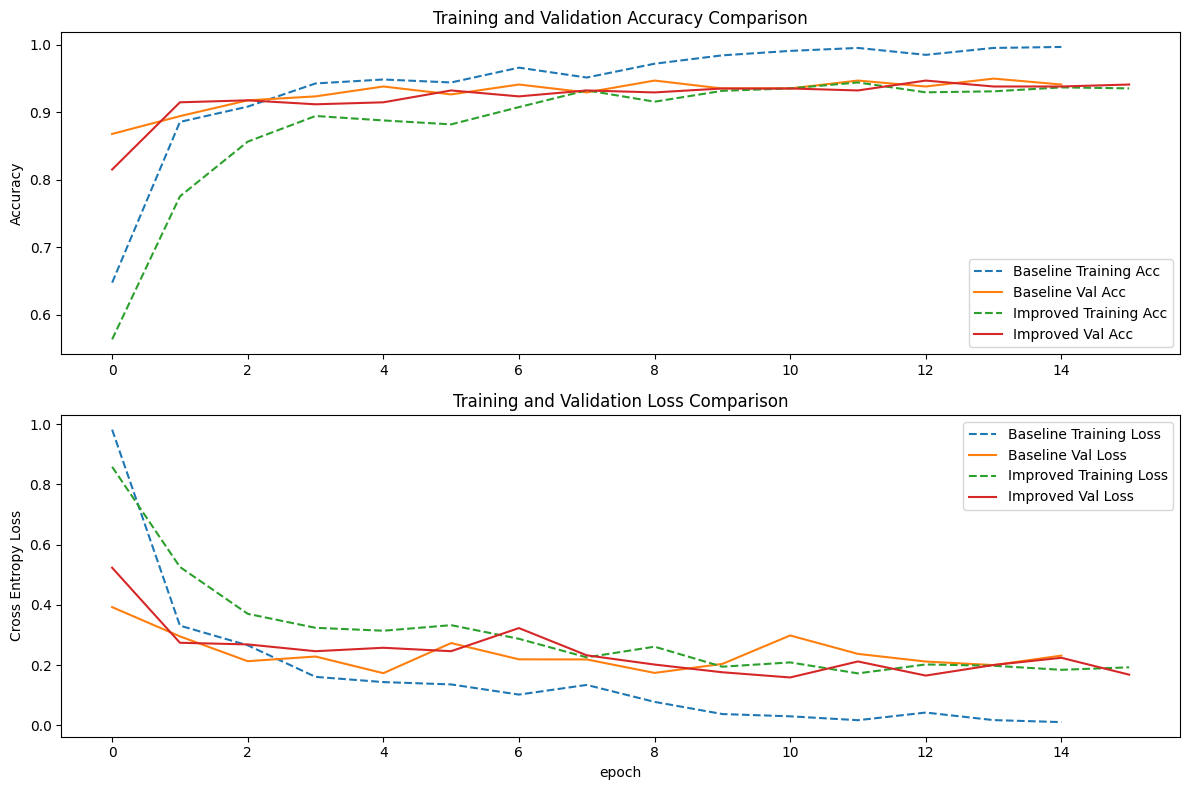

In [21]:
import matplotlib.pyplot as plt

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

acc_imp = history_improved.history['accuracy']
val_acc_imp = history_improved.history['val_accuracy']
loss_imp = history_improved.history['loss']
val_loss_imp = history_improved.history['val_loss']

plt.figure(figsize=(12, 8))

# === Accuracy Plot ===
plt.subplot(2, 1, 1)
plt.plot(acc, label='Baseline Training Acc', linestyle='--')
plt.plot(val_acc, label='Baseline Val Acc')
plt.plot(acc_imp, label='Improved Training Acc', linestyle='--')
plt.plot(val_acc_imp, label='Improved Val Acc')
plt.title("Training and Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

# === Loss Plot ===
plt.subplot(2, 1, 2)
plt.plot(loss, label='Baseline Training Loss', linestyle='--')
plt.plot(val_loss, label='Baseline Val Loss')
plt.plot(loss_imp, label='Improved Training Loss', linestyle='--')
plt.plot(val_loss_imp, label='Improved Val Loss')
plt.title("Training and Validation Loss Comparison")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("epoch")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

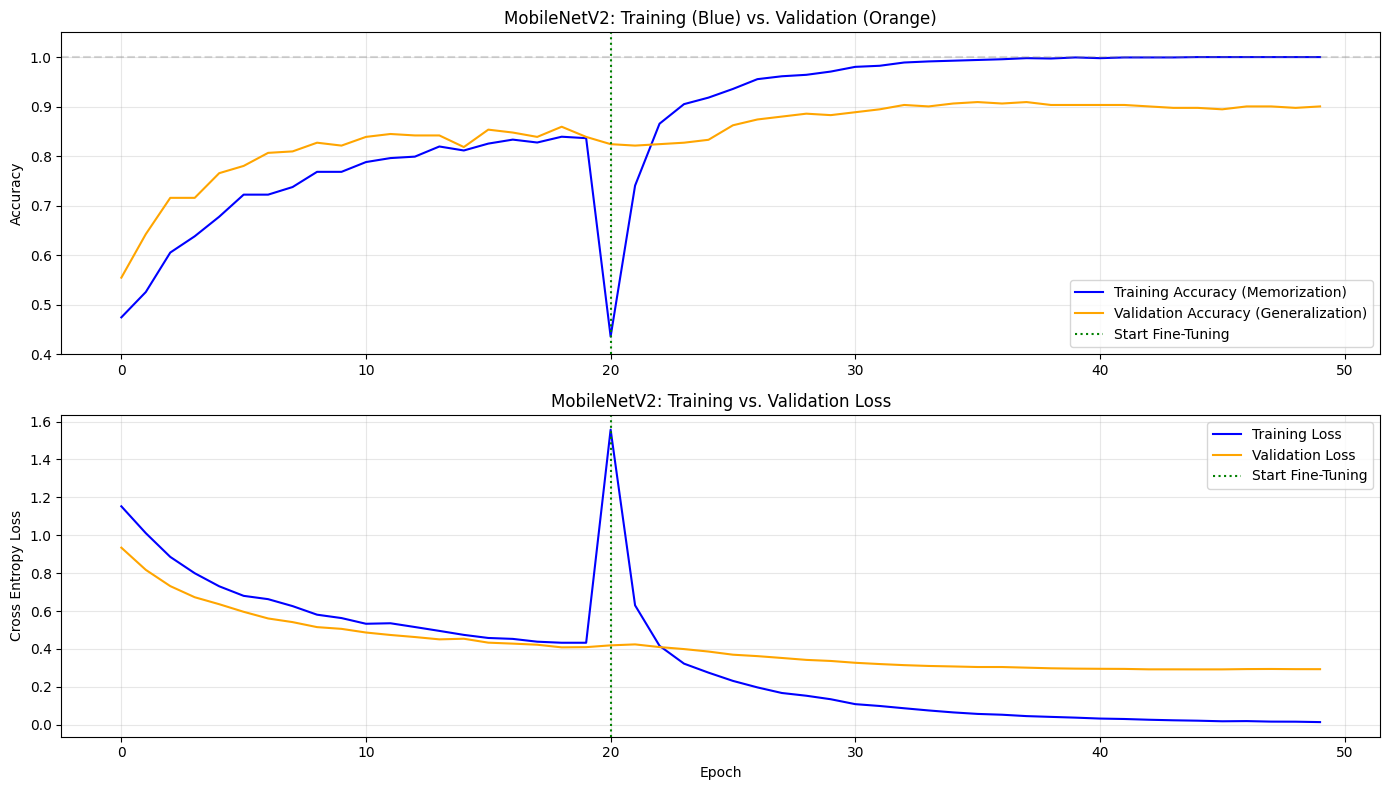

In [22]:
# ------ Plot MobileNetV2 Transfer Learning + Fine-Tuning --------
acc = history_transfer.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_transfer.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_transfer.history['loss'] + history_fine.history['loss']
val_loss = history_transfer.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(14, 8))

# === Accuracy Plot ===
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy (Memorization)', color='blue')
plt.plot(val_acc, label='Validation Accuracy (Generalization)', color='orange')
plt.axvline(x=len(history_transfer.history['accuracy']), color='green',
            linestyle=':', label='Start Fine-Tuning')
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
plt.ylabel("Accuracy")
plt.title("MobileNetV2: Training (Blue) vs. Validation (Orange)")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim([0.4, 1.05])

# === Loss Plot ===
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.axvline(x=len(history_transfer.history['accuracy']), color='green',
            linestyle=':', label='Start Fine-Tuning')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("MobileNetV2: Training vs. Validation Loss")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()